In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import random as rn

2023-11-16 12:56:44.161090: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
train_dataset = pd.read_csv('KDDTrain+.txt', header= None)
test_dataset = pd.read_csv('KDDTest+.txt', header=None)

In [ ]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

train_dataset.columns = columns
test_dataset.columns = columns

train_dataset.drop(columns=['level'], inplace=True)
test_dataset.drop(columns=['level'], inplace=True)

In [ ]:
# Target Encoding
#Mapping all attack types to their categories
dos_attacks = ['back','land','neptune','pod','smurf','teardrop', 'Apache2', 'udpstorm', 'Processtable', 'worm']
probe_attacks = ['satan', 'ipsweep', 'nmap', 'portsweep', 'Mscan', 'Saint']
R2L_attacks = ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'Xlock', 'Xsnoop', 'Snmpguess', 'Snmpgetattack', 'Httptunnel', 'Sendmail', 'Named']
U2R_attacks = ['rootkit', 'buffer_overflow', 'loadmodule', 'Perl', 'Sqlattack', 'Xterm', 'Ps']

def attack_category(attack):
    if attack in dos_attacks:
        attack_type = 1
    elif attack in probe_attacks:
        attack_type = 2
    elif attack in R2L_attacks:
        attack_type = 3
    elif attack in U2R_attacks:
        attack_type = 4
    else:
        attack_type = 0
    return attack_type

train_dataset['attack_category'] = train_dataset['attack'].apply(attack_category)
train_dataset.loc[train_dataset['attack_category'] > 0, 'is_attack'] = 1
train_dataset.loc[train_dataset['attack_category'] == 0, 'is_attack'] = 0

test_dataset['attack_category'] = test_dataset['attack'].apply(attack_category)
test_dataset.loc[test_dataset['attack_category'] > 0, 'is_attack'] = 1
test_dataset.loc[test_dataset['attack_category'] == 0, 'is_attack'] = 0

In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_hot_login', 'is_guest_login']
target = ['attack', 'is_attack', 'attack_category']
non_numerical_cols = binary_cols + categorical_cols + target
numerical_cols = [col for col in train_dataset.columns if col not in non_numerical_cols ]

In [ ]:
numerical_cols

In [ ]:
for col in categorical_cols: 
    print(f'-------- Column {col} --------')
    print(train_dataset[col].value_counts())
    print('')
    

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()

for col in categorical_cols:
    print('Encoding ' + col)
    train_dataset[col] = le.fit_transform(train_dataset[col])
    test_dataset[col] = le.transform(test_dataset[col])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for col in numerical_cols:
    print('Scaling '+ col)
    train_dataset[col] = scaler.fit_transform(np.array(train_dataset[col]).reshape(-1,1))
    test_dataset[col] = scaler.transform(np.array(test_dataset[col]).reshape(-1,1))

In [ ]:
train_dataset[numerical_cols]

In [3]:
train_pca = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree = pd.read_csv('Datasets/Tree_test_data.csv')

train_data = pd.read_csv('Datasets/train_dataset.csv')
test_data = pd.read_csv('Datasets/test_dataset.csv')

In [4]:
train_df = train_data.copy().drop(columns=['attack'])
test_df = test_data.copy().drop(columns=['attack'])

In [5]:
normal = train_df[train_df['is_attack'] == 0]
attack = train_df[train_df['is_attack'] == 1]

In [6]:
print(f"""Shape of the datasets:
    normal (rows, cols) = {normal.shape}
    attack (rows, cols) = {attack.shape}""")

Shape of the datasets:
    normal (rows, cols) = (67343, 47)
    attack (rows, cols) = (58630, 47)


In [7]:
# shuffle training data
normal = normal.sample(frac=1).reset_index(drop=True)

X_train = normal.drop(columns = ['is_attack', 'attack_category'])

In [8]:
X_train.columns

Index(['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
       'is_guest_login', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0',
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'service_encoded_freq', 'duration_scaled',
       'src_bytes_scaled', 'dst_bytes_scaled', 'wrong_fragment_scaled',
       'urgent_scaled', 'hot_scaled', 'num_failed_logins_scaled',
       'num_compromised_scaled', 'num_file_creations_scaled',
       'num_shells_scaled', 'num_access_files_scaled', 'count_scaled',
       'srv_count_scaled', 'same_srv_rate_scaled', 'diff_srv_rate_scaled',
       'srv_diff_host_rate_scaled', 'dst_host_count_scaled',
       'dst_host_srv_count_scaled', 'dst_host_same_srv_rate_scaled',
       'dst_host_diff_srv_rate_scaled', 'dst_host_same_src_port_rate_scaled',
       'dst_host_srv_diff_host_rate_scaled', 'serror_rate_combined',
       'rerror_rat

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_validate = train_test_split(X_train, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED)

X_all, y_all, attack_cat_all = train_df.drop(columns=['is_attack', 'attack_category']), train_df['is_attack'], train_df['attack_category']

X_test, y_test, attack_cat = test_df.drop(columns=['is_attack', 'attack_category']), test_data['is_attack'], test_data['attack_category']


In [10]:
print(X_test.columns)

Index(['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
       'is_guest_login', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0',
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'service_encoded_freq', 'duration_scaled',
       'src_bytes_scaled', 'dst_bytes_scaled', 'wrong_fragment_scaled',
       'urgent_scaled', 'hot_scaled', 'num_failed_logins_scaled',
       'num_compromised_scaled', 'num_file_creations_scaled',
       'num_shells_scaled', 'num_access_files_scaled', 'count_scaled',
       'srv_count_scaled', 'same_srv_rate_scaled', 'diff_srv_rate_scaled',
       'srv_diff_host_rate_scaled', 'dst_host_count_scaled',
       'dst_host_srv_count_scaled', 'dst_host_same_srv_rate_scaled',
       'dst_host_diff_srv_rate_scaled', 'dst_host_same_src_port_rate_scaled',
       'dst_host_srv_diff_host_rate_scaled', 'serror_rate_combined',
       'rerror_rat

In [11]:
print(f"""samples in the test datasets:
    normal (rows, cols) = {test_data[test_data['is_attack'] == 0].shape[0]}
    attack (rows, cols) = {test_data[test_data['is_attack'] == 1].shape[0]}""")

samples in the test datasets:
    normal (rows, cols) = 9711
    attack (rows, cols) = 12833


In [12]:
print(f"""Shape of the datasets:
    training (non-attack)(rows, cols) = {X_train.shape}
    validate (non-attack)(rows, cols) = {X_validate.shape}
    validate (mix)    (rows, cols) = {X_all.shape}
    holdout  (mix)       (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (non-attack)(rows, cols) = (53874, 45)
    validate (non-attack)(rows, cols) = (13469, 45)
    validate (mix)    (rows, cols) = (125973, 45)
    holdout  (mix)       (rows, cols) = (22544, 45)


In [34]:
input_dim = X_train.shape[1]
BATCH_SIZE = 64
EPOCHS = 70

autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l2(10e-5), input_shape=(input_dim, )), 
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

autoencoder.compile(optimizer="rmsprop", 
                    loss="mse")

# print an overview of our model
autoencoder.summary();

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 45)                2070      
                                                                 
 dense_17 (Dense)            (None, 300)               13800     
                                                                 
 dense_18 (Dense)            (None, 100)               30100     
                                                                 
 dense_19 (Dense)            (None, 25)                2525      
                                                                 
 dense_20 (Dense)            (None, 25)                650       
                                                                 
 dense_21 (Dense)            (None, 100)               2600      
                                                                 
 dense_22 (Dense)            (None, 300)              

In [35]:
auto_history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate, X_validate)
);

Epoch 1/70
842/842 [==============================] - 3s 3ms/step - loss: 0.0149 - val_loss: 0.0063
Epoch 2/70
842/842 [==============================] - 3s 3ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 3/70
842/842 [==============================] - 4s 4ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/70
842/842 [==============================] - 4s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/70
842/842 [==============================] - 5s 5ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/70
842/842 [==============================] - 6s 7ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/70
842/842 [==============================] - 7s 8ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/70
842/842 [==============================] - 6s 8ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/70
842/842 [==============================] - 5s 6ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/70
842/842 [==============================] - 5s 6ms/step - loss: 0.0024 - val_loss: 0.0025

In [ ]:
input_dim = X_train.shape[1]
BATCH_SIZE = 64
EPOCHS = 50

autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(300, activation='relu', activity_regularizer=tf.keras.regularizers.l2(10e-5), input_shape=(input_dim, )),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

autoencoder.compile(optimizer="rmsprop", 
                    loss="mse")

# print an overview of our model
autoencoder.summary();

In [ ]:
auto_history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate, X_validate)
);

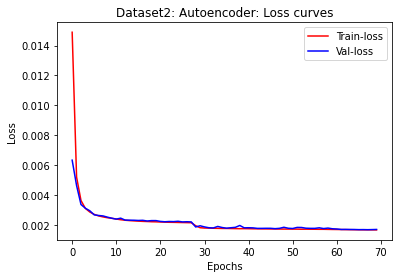

In [36]:
plt.plot(range(70), auto_history.history['loss'],'r', label='Train-loss')
plt.plot(range(70), auto_history.history['val_loss'],'b', label='Val-loss')
plt.title('Dataset2: Autoencoder: Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

3937/3937 [==============================] - 7s 2ms/step


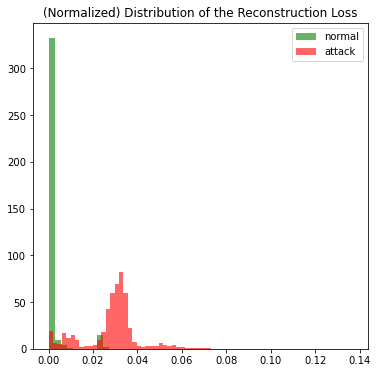

In [37]:
reconstructions_train = autoencoder.predict(X_all)
mse_train = np.mean(np.power(X_all - reconstructions_train, 2), axis=1)

normal_train = mse_train[y_all==0]
attack_train = mse_train[y_all==1]

normal_train = [x for x in normal_train if x < 100]
attack_train = [x for x in attack_train if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_train, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_train, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, classification_report, f1_score)

def classify(THRESHOLD, mse, y):
    m = np.median(mse)
    ad = np.abs(mse - m)
    mad = np.median(ad)
    z_scores = 0.6745 * ad / mad
    
    outliers = z_scores > THRESHOLD
    mse_threshold = m + THRESHOLD * mad / 0.6745 
    
    print(f"Detected {np.sum(outliers):,} intrusions in a total of {np.size(z_scores):,} events [{np.sum(outliers)/np.size(z_scores):.2%}].")

    # get (mis)classification
    cm = confusion_matrix(y, outliers)

    # true/false positives/negativesb
    (tn, fp, 
     fn, tp) = cm.flatten()
    
    print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
    {cm}

    % of events labeled as intrusion that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
    % of intrusion were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
    
    print(classification_report(y, outliers))
    print("F1 score : " + str(f1_score(y, outliers)))
    
    return outliers, mse_threshold
    

In [39]:
predicted_train, mse_threshold_train = classify(1, mse_train, y_all)

Detected 59,720 intrusions in a total of 125,973 events [47.41%].
The classifications using the MAD method with threshold=1 are as follows:
    [[62985  4358]
 [ 3268 55362]]

    % of events labeled as intrusion that were correct (precision): 55362/(4358+55362) = 92.70%
    % of intrusion were caught succesfully (recall):    55362/(3268+55362) = 94.43%
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94     67343
         1.0       0.93      0.94      0.94     58630

    accuracy                           0.94    125973
   macro avg       0.94      0.94      0.94    125973
weighted avg       0.94      0.94      0.94    125973

F1 score : 0.9355640050697085


In [40]:
train_df['predicted_intrusion'] = predicted_train
train_df['mse'] = mse_train
train_df['predicted_intrusion'] = train_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)

In [41]:
train_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      62985
                 1                       4358
1                0                       1052
                 1                      44875
2                0                       1583
                 1                      10073
3                0                        610
                 1                        385
4                0                         23
                 1                         29
Name: count_scaled, dtype: int64

In [42]:
print(mse_threshold_train)

0.005464089423791908


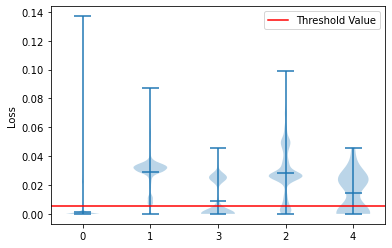

In [43]:
classes = train_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([train_df[train_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_train,c='r',label="Threshold Value")
plt.legend();

In [44]:
reconstructions_test = autoencoder.predict(X_test)

705/705 [==============================] - 1s 1ms/step


In [45]:
mse_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

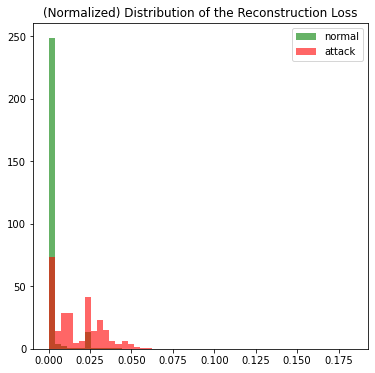

In [46]:
normal_test = mse_test[y_test==0]
attack_test = mse_test[y_test==1]

normal_test = [x for x in normal_test if x < 100]
attack_test = [x for x in attack_test if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_test, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_test, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [47]:
predicted_test, mse_threshold_test = classify(1, mse_test, y_test)

Detected 10,316 intrusions in a total of 22,544 events [45.76%].
The classifications using the MAD method with threshold=1 are as follows:
    [[8822  889]
 [3406 9427]]

    % of events labeled as intrusion that were correct (precision): 9427/(889+9427) = 91.38%
    % of intrusion were caught succesfully (recall):    9427/(3406+9427) = 73.46%
              precision    recall  f1-score   support

         0.0       0.72      0.91      0.80      9711
         1.0       0.91      0.73      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.83      0.81      0.81     22544

F1 score : 0.8144628277679382


In [48]:
test_df['predicted_intrusion'] = predicted_test
test_df['mse'] = mse_test
test_df['predicted_intrusion'] = test_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)

In [49]:
test_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      8822
                 1                       889
1                0                       807
                 1                      6653
2                0                       483
                 1                      1938
3                0                      2087
                 1                       798
4                0                        29
                 1                        38
Name: count_scaled, dtype: int64

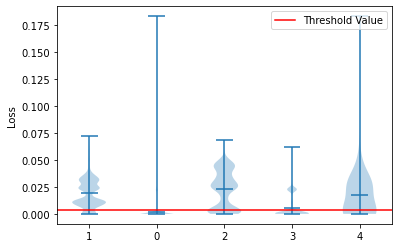

In [50]:
classes = test_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([test_df[test_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_test,c='r',label="Threshold Value")
plt.legend();

## Model 2

In [89]:
train_xformed = train_data.copy().drop(columns =["attack"])
test_xformed = test_data.copy().drop(columns =["attack"])

In [90]:
train_xformed.columns


Index(['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
       'is_guest_login', 'protocol_type_icmp', 'protocol_type_tcp',
       'protocol_type_udp', 'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0',
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'service_encoded_freq', 'attack_category', 'is_attack',
       'duration_scaled', 'src_bytes_scaled', 'dst_bytes_scaled',
       'wrong_fragment_scaled', 'urgent_scaled', 'hot_scaled',
       'num_failed_logins_scaled', 'num_compromised_scaled',
       'num_file_creations_scaled', 'num_shells_scaled',
       'num_access_files_scaled', 'count_scaled', 'srv_count_scaled',
       'same_srv_rate_scaled', 'diff_srv_rate_scaled',
       'srv_diff_host_rate_scaled', 'dst_host_count_scaled',
       'dst_host_srv_count_scaled', 'dst_host_same_srv_rate_scaled',
       'dst_host_diff_srv_rate_scaled', 'dst_host_same_src_port_rate_scaled',
       'dst_host_srv_diff_host_rate_scaled', 'se

In [91]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Initialize One-Hot Encoder
encoder = OneHotEncoder(handle_unknown="ignore")

## Protocol type
# Fit encoder on training data (returns a separate DataFrame)
data_ohe = pd.DataFrame(encoder.fit_transform(train_xformed[["service_encoded_freq"]]).toarray())
data_ohe.columns = [("service" + str(col)) for col in encoder.categories_[0]]

# Join encoded data with original training data
train_xformed = pd.concat([train_xformed, data_ohe], axis=1)
train_xformed.drop(columns=['service_encoded_freq'], inplace=True)

# Transform test data (returns a separate DataFrame)
data_ohe = pd.DataFrame(encoder.transform(test_xformed[["service_encoded_freq"]]).toarray())
data_ohe.columns = [("service" + str(col)) for col in encoder.categories_[0]]

# Join encoded data with original test data
test_xformed = pd.concat([test_xformed, data_ohe], axis=1)
test_xformed.drop(columns=['service_encoded_freq'], inplace=True)

In [92]:
from sklearn.model_selection import train_test_split

train_df = train_xformed
test_df = test_xformed

normal = train_df[train_df['is_attack'] == 0]
attack = test_df[test_df['is_attack'] == 1]

# shuffle training data
normal = normal.sample(frac=1).reset_index(drop=True)

X_train = normal.drop(columns = ['is_attack', 'attack_category'])

X_train, X_validate = train_test_split(X_train, 
                                       test_size=0.2, 
                                       random_state=RANDOM_SEED)

X_all, y_all, attack_cat_all = train_df.drop(columns=['is_attack', 'attack_category']), train_df['is_attack'], train_df['attack_category']

X_test, y_test, attack_cat = test_df.drop(columns=['is_attack', 'attack_category']), test_data['is_attack'], test_data['attack_category']



In [110]:
input_dim = X_train.shape[1]
BATCH_SIZE = 100
EPOCHS = 50

autoencoder2 = tf.keras.models.Sequential([
    # deconstruct / encode
    tf.keras.layers.Dropout(.5, input_shape=(input_dim,)),
    tf.keras.layers.Dense(8, activation='relu', activity_regularizer=tf.keras.regularizers.l2(10e-5)),

    # reconstruction / decode
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

autoencoder2.compile(optimizer="adam", 
                    loss="mse")

# print an overview of our model
autoencoder2.summary();

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 110)               0         
                                                                 
 dense_30 (Dense)            (None, 8)                 888       
                                                                 
 dense_31 (Dense)            (None, 110)               990       
                                                                 
Total params: 1,878
Trainable params: 1,878
Non-trainable params: 0
_________________________________________________________________


In [111]:
auto_history2 = autoencoder2.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate, X_validate)
);

Epoch 1/50
539/539 [==============================] - 2s 2ms/step - loss: 0.0226 - val_loss: 0.0098
Epoch 2/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0075
Epoch 3/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0067
Epoch 4/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0063
Epoch 5/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0061
Epoch 6/50
539/539 [==============================] - 3s 6ms/step - loss: 0.0101 - val_loss: 0.0060
Epoch 7/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 0.0060
Epoch 8/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0058
Epoch 9/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0058
Epoch 10/50
539/539 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0058

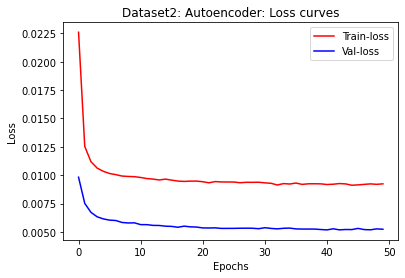

In [112]:
plt.plot(range(50), auto_history2.history['loss'],'r', label='Train-loss')
plt.plot(range(50), auto_history2.history['val_loss'],'b', label='Val-loss')
plt.title('Dataset2: Autoencoder: Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

3937/3937 [==============================] - 4s 958us/step


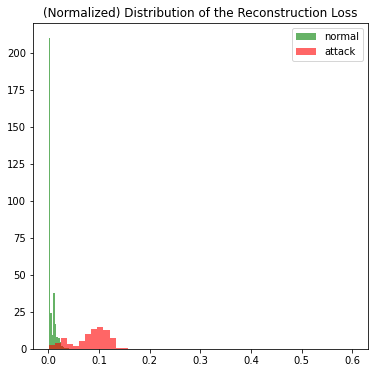

In [113]:
reconstructions_train = autoencoder2.predict(X_all)
mse_train = np.mean(np.power(X_all - reconstructions_train, 2), axis=1)

normal_train = mse_train[y_all==0]
attack_train = mse_train[y_all==1]

normal_train = [x for x in normal_train if x < 100]
attack_train = [x for x in attack_train if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_train, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_train, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [114]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, classification_report, f1_score)

def classify(THRESHOLD, mse, y):
    m = np.median(mse)
    ad = np.abs(mse - m)
    mad = np.median(ad)
    z_scores = 0.6745 * ad / mad
    
    outliers = z_scores > THRESHOLD
    mse_threshold = m + THRESHOLD * mad / 0.6745 
    
    print(f"Detected {np.sum(outliers):,} intrusions in a total of {np.size(z_scores):,} events [{np.sum(outliers)/np.size(z_scores):.2%}].")

    # get (mis)classification
    cm = confusion_matrix(y, outliers)

    # true/false positives/negativesb
    (tn, fp, 
     fn, tp) = cm.flatten()
    
    print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
    {cm}

    % of events labeled as intrusion that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
    % of intrusion were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
    
    print(classification_report(y, outliers))
    print("F1 score : " + str(f1_score(y, outliers)))
    
    return outliers, mse_threshold
    

In [115]:
predicted_train, mse_threshold_train = classify(1, mse_train, y_all)

Detected 49,633 intrusions in a total of 125,973 events [39.40%].
The classifications using the MAD method with threshold=1 are as follows:
    [[66986   357]
 [ 9354 49276]]

    % of events labeled as intrusion that were correct (precision): 49276/(357+49276) = 99.28%
    % of intrusion were caught succesfully (recall):    49276/(9354+49276) = 84.05%
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     67343
         1.0       0.99      0.84      0.91     58630

    accuracy                           0.92    125973
   macro avg       0.94      0.92      0.92    125973
weighted avg       0.93      0.92      0.92    125973

F1 score : 0.9103017651459872


In [116]:
train_df['predicted_intrusion'] = predicted_train
train_df['mse'] = mse_train
train_df['predicted_intrusion'] = train_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)

In [132]:
threshold_new = auto_history2.history['loss'][-1]
train_df['predicted_intrusion2'] = train_df['mse'].apply(lambda x: 1 if x > threshold_new else 0)

In [133]:
print(classification_report(y_all, train_df['predicted_intrusion2']))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     67343
         1.0       0.78      0.97      0.86     58630

    accuracy                           0.86    125973
   macro avg       0.87      0.86      0.86    125973
weighted avg       0.88      0.86      0.85    125973



In [135]:
train_df.groupby(['attack_category', 'predicted_intrusion2'])['count_scaled'].count()

attack_category  predicted_intrusion2
0                0                       50825
                 1                       16518
1                0                         765
                 1                       45162
2                0                         173
                 1                       11483
3                0                         732
                 1                         263
4                0                           8
                 1                          44
Name: count_scaled, dtype: int64

In [117]:
train_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      66986
                 1                        357
1                0                       2626
                 1                      43301
2                0                       5756
                 1                       5900
3                0                        927
                 1                         68
4                0                         45
                 1                          7
Name: count_scaled, dtype: int64

In [118]:
print(mse_threshold_train)

0.03412879505744541


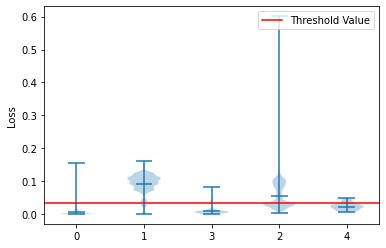

In [119]:
classes = train_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([train_df[train_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_train,c='r',label="Threshold Value")
plt.legend();

In [120]:
reconstructions_test = autoencoder2.predict(X_test)

705/705 [==============================] - 1s 1ms/step


In [121]:
mse_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

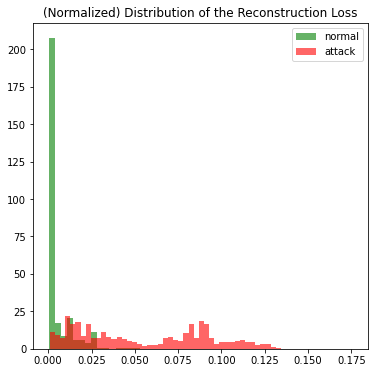

In [122]:
normal_test = mse_test[y_test==0]
attack_test = mse_test[y_test==1]

normal_test = [x for x in normal_test if x < 100]
attack_test = [x for x in attack_test if x < 100]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_test, bins=50, density=True, label="normal", alpha = 0.6, color="green")
ax.hist(attack_test, bins=50, density=True, label="attack", alpha = 0.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [129]:
predicted_test, mse_threshold_test = classify(1, mse_test, y_test)

Detected 7,389 intrusions in a total of 22,544 events [32.78%].
The classifications using the MAD method with threshold=1 are as follows:
    [[9629   82]
 [5526 7307]]

    % of events labeled as intrusion that were correct (precision): 7307/(82+7307) = 98.89%
    % of intrusion were caught succesfully (recall):    7307/(5526+7307) = 56.94%
              precision    recall  f1-score   support

         0.0       0.64      0.99      0.77      9711
         1.0       0.99      0.57      0.72     12833

    accuracy                           0.75     22544
   macro avg       0.81      0.78      0.75     22544
weighted avg       0.84      0.75      0.74     22544

F1 score : 0.7226782711897933


In [124]:
test_df['predicted_intrusion'] = predicted_test
test_df['mse'] = mse_test
test_df['predicted_intrusion'] = test_df['predicted_intrusion'].apply(lambda x: 1 if x == True else 0)

In [125]:
test_df.groupby(['attack_category', 'predicted_intrusion'])['count_scaled'].count()

attack_category  predicted_intrusion
0                0                      9629
                 1                        82
1                0                      1866
                 1                      5594
2                0                       738
                 1                      1683
3                0                      2859
                 1                        26
4                0                        63
                 1                         4
Name: count_scaled, dtype: int64

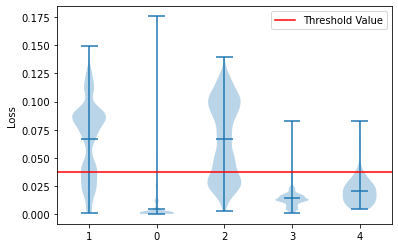

In [126]:
classes = test_df['attack_category'].unique()
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([test_df[test_df['attack_category'] == class_]['mse'] for class_ in classes], np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=mse_threshold_test,c='r',label="Threshold Value")
plt.legend();